# Introduction
Mean Absolute Deviation (MAD) is a significant metric in the financial domain. It provides a more contextual view of stock price movements by comparing them to historical volatility. Unlike the usual percentage-based movement representation, MAD provides a more granular understanding of how significant a stock's movement is

This notebook is inspired from https://squeezemetrics.com/

Original Works by Jeremy Myo.

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

from datetime import datetime

import base64
import io

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Calculate Monthly Average Movement
This function computes the average absolute percentage change of a stock's adjusted closing prices over the past month.

Parameters:
data: The stock dataset, indexed by date.
current_date: The reference date for which we calculate the average movement of the preceding month.
Returns:
The monthly average absolute percentage movement of the adjusted closing prices.

### Calculate MAD Returns

After determining the monthly average movement, we compute the MAD returns. This function provides insights into how a specific day's movement correlates with the average monthly movement.

Parameters:
monthly_avg_movement_absolute: The computed average absolute movement for a specific month.
daily_movement: The daily percentage change of stock prices.
Returns:
The MAD return, which quantifies the significance of a particular day's price movement in relation to the average monthly movement.

### Find the Nearest Milestone

This utility function identifies the nearest milestone for a given number of years. It's especially useful when pinpointing significant time-related events or milestones.

Parameters:
years: The number of years for which we need to find the nearest milestone.
Returns:
The closest milestone, chosen from a predefined list, corresponding to the input number of years.

In [10]:
tickers = ['^SPX', 'IEF', 'GLD','LQD']
start_date = '2005-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
look_back_time = 6 #6months
frequency = 'monthly' # monthly

data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()

[*********************100%***********************]  4 of 4 completed


In [11]:
# Step 1: Calculate monthly average movement
def calculate_monthly_average_absolute(data, current_date):
    end_date = pd.Timestamp(current_date) - pd.DateOffset(days=1)

    start_date = pd.Timestamp(end_date) - pd.DateOffset(months=1)

    monthly_data = data.loc[start_date:end_date]

    monthly_avg_movement_absolute = abs(monthly_data['Adj Close'].pct_change()).mean() * 100
    
    return monthly_avg_movement_absolute


# Step 3: Calculate MAD
def calculate_mad_returns(monthly_avg_movement_absolute, daily_movement):
    mad = daily_movement / monthly_avg_movement_absolute

    return mad


def nearest_milestone(years):
    milestones = [5, 10, 20]
    closest = min(milestones, key=lambda x:abs(x-years))
    return closest

### MAD Heatmap Plot Function Documentation

#### Overview

This function visualizes the relationship between MAD Price, MAD Volatility, and the forward price change of a stock over a specified future period.

#### Function: `plot_mad_heatmap_html`

#### Parameters:

- **ticker**: The ticker symbol of the stock.
- **start_date**: The start date for downloading the stock data.
- **end_date**: The end date for downloading the stock data.
- **list_of_dates**: A list of specific dates that will be highlighted in the heatmap.
- **months_forward**: The number of months forward to calculate the forward price change.

#### Process:

1. **Initialize and Download Data**
    - Set display options for pandas DataFrame.
    - Download daily stock data using Yahoo Finance.
  
2. **Pre-process and Compute Metrics**
    - Compute rolling volatility, daily percentage change, and MAD volatility.
    - Calculate the forward price and its percentage change for the `months_forward` period.
    - Iterate to compute monthly average movement, MAD return, and aggregate MAD values.
  
3. **Create the MAD Table**
    - Construct a DataFrame (`mad_table`) with MAD Price, MAD Return, MAD Volatility, etc.
    - Filter out NaN values in the forward price change column.
    - Bin MAD Price and MAD Volatility into groups. Label with the bin's midpoint.
  
4. **Heatmap Creation**
    - Create a pivot table for average forward price change % based on MAD Price and MAD Volatility bins.
    - Mask out cells with a value of 0.
    - Plot the heatmap using seaborn. Cells are color-coded by forward price change %.
    - Overlay specified dates from `list_of_dates` on the heatmap.
  
5. **Image Processing**
    - Convert the heatmap into an HTML-compatible format.

#### Returns:

- HTML `img` tag with the base64 encoded PNG image of the heatmap.



In [12]:
def plot_mad_heatmap_html(ticker, start_date, end_date, list_of_dates, months_forward):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    ticker_name = yf.Ticker(ticker).info['symbol']
    look_forward_window = -(months_forward * 21)
#     look_forward_window = months_forward
    
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    month_name = '{}-Month_Forward_Price'.format(months_forward)
    
    start_of_all = data.index.min().strftime('%Y-%m-%d')
    difference = datetime.strptime(end_date, "%Y-%m-%d") -datetime.strptime(start_of_all, "%Y-%m-%d")
    years_historical = nearest_milestone(difference.days / 365.25)
    
    
    mad_list = []
    mad_list_dummy =[]
    monthly_avg_movement_list = []

    data['RollingVolatility'] = data['Adj Close'].pct_change().rolling(window=20).std() * 100

    data['dailychange'] = data['Adj Close'].pct_change()

    data['MAD_Volatility'] = data['dailychange'] - data['dailychange'].shift(1)

    # Create a new column for the 3-month forward price
    data['{}-Month_Forward_Price'.format(months_forward)] = data['Adj Close'].shift(look_forward_window) 

    # Create a new column for the 3-month forward price change
    data['{}-Month_Forward_Price_Change%'.format(months_forward)] = (data['{}-Month_Forward_Price'.format(months_forward)] - data['Adj Close']) / data['Adj Close'] * 100



    for date in data.index[1:]:
        priceReal = data.loc[date, 'Adj Close']
        pct_change = data.loc[date, 'dailychange'] * 100
        mad_vol = data.loc[date, 'MAD_Volatility'] * 100
        forwardp = data.loc[date,'{}-Month_Forward_Price_Change%'.format(months_forward)]

        monthly_avg_movement = calculate_monthly_average_absolute(data, date)
        monthly_avg_movement_list.append(monthly_avg_movement)

        mad = calculate_mad_returns(monthly_avg_movement, pct_change)
        mad_list_dummy.append(mad)

        if len(mad_list_dummy) > 20:
            mad_list_dummy = mad_list_dummy[-20:]  # Keep only the last 20 MAD values
            price = (sum(mad_list_dummy)) / (np.std(mad_list_dummy)*math.sqrt(20))
            vol = (monthly_avg_movement_list[-1] - monthly_avg_movement_list[-2])

            mad_list.append({'Date': date,'MAD_Price': price, 'MAD_Return': mad, 'MAD_Vol':vol,
                             'Abs_Daily_avg(1M Lookback) %':monthly_avg_movement,
                            'Mkt_Closing_Price':priceReal, 'Daily_change_pct':pct_change,
                            '{}-Month Future %'.format(months_forward):forwardp})


    mad_table = pd.DataFrame(mad_list)

    
    # Drop rows with NaN values in '3-Month Future %'
    mad_tableA = mad_table.dropna(subset=['{}-Month Future %'.format(months_forward)]).copy()

    # Bin 'MAD_Price' and 'MAD_Vol' into 10 groups and keep the midpoint of each bin as the label
    mad_tableA['MAD_Price_Bins'] = pd.cut(mad_tableA['MAD_Price'], bins=20).apply(lambda x: round(x.mid, 2))
    mad_tableA['MAD_Vol_Bins'] = pd.cut(mad_tableA['MAD_Vol'], bins=20).apply(lambda x: round(x.mid, 2))

    # Create a pivot table
    pivot_tableA = mad_tableA.pivot_table(values='{}-Month Future %'.format(months_forward), 
                                        index='MAD_Price_Bins', 
                                        columns='MAD_Vol_Bins', 
                                        aggfunc='mean', 
                                        fill_value=0)

    # Create a mask where values are 0
    mask = pivot_tableA ==0

    # Define a custom color map
    cmap = LinearSegmentedColormap.from_list(name='redGreen', 
                                             colors=['red', 'white', 'green'])

    # Define the center of the colormap
    norm = TwoSlopeNorm(vmin=pivot_tableA.min().min(), vcenter=0, vmax=pivot_tableA.max().max())


    # Increase the font size
    sns.set(font_scale=1.2)

    # Generate a heatmap
    plt.figure(figsize=(20,16))
    sns.heatmap(pivot_tableA, cmap=cmap, annot=True, fmt=".2f", mask=mask, norm=norm)
    plt.title('{} {}-Month Forward Price Change % ({}Y)'.format(ticker_name,months_forward,years_historical))

    # Invert y-axis
    plt.gca().invert_yaxis()

    date_colors = ['orange', 'blue', 'grey', 'violet']

    patches = []
    
    for idx, date in enumerate(list_of_dates):
        current_price = mad_table.loc[mad_table['Date'] == date, 'MAD_Price'].values[0].round(2)
        current_vol = mad_table.loc[mad_table['Date'] == date, 'MAD_Vol'].values[0].round(2)
        current_date = date

        current_price_bin = np.digitize(current_price, pivot_tableA.index.values) - 1
        current_vol_bin = np.digitize(current_vol, pivot_tableA.columns.values) - 1
        current_price_bin = min(max(current_price_bin, 0), len(pivot_tableA.index) - 1)
        current_vol_bin = min(max(current_vol_bin, 0), len(pivot_tableA.columns) - 1)

        plt.scatter(current_vol_bin+0.5, current_price_bin+0.5, color=date_colors[idx], marker='x', s=500)

        patch = mpatches.Patch(color=date_colors[idx], 
                               label='{}\n(Price = {}, Volatility = {})'.format(current_date, current_price, current_vol))
        patches.append(patch)

    plt.legend(handles=patches, loc='lower left')
    
    image_stream = io.BytesIO()
    plt.savefig(image_stream, format='png')
    plt.close()

    # Rewind the stream to the beginning
    image_stream.seek(0)

    # Convert the BytesIO stream to a base64 string
    image_base64 = base64.b64encode(image_stream.read()).decode('utf-8')

    # Format the base64 string as an HTML img tag
    image_html = f'<img src="data:image/png;base64,{image_base64}" />'

    return image_html



In [15]:
def plot_mad_heatmap_to_pdf(ticker, start_date, end_date, list_of_dates, months_forward, pdf_pages):
    
    ticker_name = yf.Ticker(ticker).info['shortName']
    look_forward_window = -(months_forward * 21)
    # look_forward_window = months_forward
    
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    month_name = '{}-Month_Forward_Price'.format(months_forward)
    
    start_of_all = data.index.min().strftime('%Y-%m-%d')
    difference = datetime.strptime(end_date, "%Y-%m-%d") -datetime.strptime(start_of_all, "%Y-%m-%d")
    years_historical = nearest_milestone(difference.days / 365.25)
    
    
    mad_list = []
    mad_list_dummy =[]
    monthly_avg_movement_list = []

    data['RollingVolatility'] = data['Adj Close'].pct_change().rolling(window=20).std() * 100

    data['dailychange'] = data['Adj Close'].pct_change()

    data['MAD_Volatility'] = data['dailychange'] - data['dailychange'].shift(1)

    # Create a new column for the 3-month forward price
    data['{}-Month_Forward_Price'.format(months_forward)] = data['Adj Close'].shift(look_forward_window) 

    # Create a new column for the 3-month forward price change
    data['{}-Month_Forward_Price_Change%'.format(months_forward)] = (data['{}-Month_Forward_Price'.format(months_forward)] - data['Adj Close']) / data['Adj Close'] * 100



    for date in data.index[1:]:
        priceReal = data.loc[date, 'Adj Close']
        pct_change = data.loc[date, 'dailychange'] * 100
        mad_vol = data.loc[date, 'MAD_Volatility'] * 100
        forwardp = data.loc[date,'{}-Month_Forward_Price_Change%'.format(months_forward)]

        monthly_avg_movement = calculate_monthly_average_absolute(data, date)
        monthly_avg_movement_list.append(monthly_avg_movement)

        mad = calculate_mad_returns(monthly_avg_movement, pct_change)
        mad_list_dummy.append(mad)

        if len(mad_list_dummy) > 20:
            mad_list_dummy = mad_list_dummy[-20:]  # Keep only the last 20 MAD values
            price = (sum(mad_list_dummy)) / (np.std(mad_list_dummy)*math.sqrt(20))
            vol = (monthly_avg_movement_list[-1] - monthly_avg_movement_list[-2])

            mad_list.append({'Date': date,'MAD_Price': price, 'MAD_Return': mad, 'MAD_Vol':vol,
                             'Abs_Daily_avg(1M Lookback) %':monthly_avg_movement,
                            'Mkt_Closing_Price':priceReal, 'Daily_change_pct':pct_change,
                            '{}-Month Future %'.format(months_forward):forwardp})


    mad_table = pd.DataFrame(mad_list)

    
    # Drop rows with NaN values in '3-Month Future %'
    mad_tableA = mad_table.dropna(subset=['{}-Month Future %'.format(months_forward)]).copy()

    # Bin 'MAD_Price' and 'MAD_Vol' into 10 groups and keep the midpoint of each bin as the label
    mad_tableA['MAD_Price_Bins'] = pd.cut(mad_tableA['MAD_Price'], bins=20).apply(lambda x: round(x.mid, 2))
    mad_tableA['MAD_Vol_Bins'] = pd.cut(mad_tableA['MAD_Vol'], bins=20).apply(lambda x: round(x.mid, 2))

    # Create a pivot table
    pivot_tableA = mad_tableA.pivot_table(values='{}-Month Future %'.format(months_forward), 
                                        index='MAD_Price_Bins', 
                                        columns='MAD_Vol_Bins', 
                                        aggfunc='mean', 
                                        fill_value=0)

    # Create a mask where values are 0
    mask = pivot_tableA ==0

    # Define a custom color map
    cmap = LinearSegmentedColormap.from_list(name='redGreen', 
                                             colors=['red', 'white', 'green'])

    # Define the center of the colormap
    norm = TwoSlopeNorm(vmin=pivot_tableA.min().min(), vcenter=0, vmax=pivot_tableA.max().max())


    # Increase the font size
    sns.set(font_scale=1.2)

    # Generate a heatmap
    plt.figure(figsize=(20,16))
    sns.heatmap(pivot_tableA, cmap=cmap, annot=True, fmt=".2f", mask=mask, norm=norm)
    
    plt.title('{} {}-Month Forward Price Change % ({}Y)'.format(ticker_name,months_forward,years_historical))
    # Invert y-axis
    plt.gca().invert_yaxis()

    date_colors = ['orange', 'blue', 'grey', 'violet']

    patches = []
    for idx, date in enumerate(list_of_dates):
        current_price = mad_table.loc[mad_table['Date'] == date, 'MAD_Price'].values[0].round(2)
        current_vol = mad_table.loc[mad_table['Date'] == date, 'MAD_Vol'].values[0].round(2)
        current_date = date

        current_price_bin = np.digitize(current_price, pivot_tableA.index.values) - 1
        current_vol_bin = np.digitize(current_vol, pivot_tableA.columns.values) - 1
        current_price_bin = min(max(current_price_bin, 0), len(pivot_tableA.index) - 1)
        current_vol_bin = min(max(current_vol_bin, 0), len(pivot_tableA.columns) - 1)

        plt.scatter(current_vol_bin+0.5, current_price_bin+0.5, color=date_colors[idx], marker='x', s=500)

        patch = mpatches.Patch(color=date_colors[idx], 
                               label='{}\n(Price = {}, Volatility = {})'.format(current_date, current_price, current_vol))
        patches.append(patch)

    plt.legend(handles=patches, loc='lower left')
    pdf_pages.savefig() # Save the current figure to the PDF

### MAD Heat Map Generation and PDF Export

#### Overview

The code aims to generate MAD heat maps for a list of stock tickers and then export them to PDF files.##

## Process:

1. **Initialization**
    - A list of target tickers, `realt`, is defined which includes symbols like `^IXIC`, `BTC-USD`, and `ETH-USD`.
    - An empty list, `pdf_filenames`, is initialized to store the names of the generated PDF files.

2. **Iterating through Tickers**
    - For each ticker in the `realt` list:
        1. Open a new PDF file named after the ticker's short name (retrieved using Yahoo Finance).
        2. For each time period in `[1,3,6,12]` (representing different months forward):
            - Generate the MAD heat map for the given ticker and time period using the function `plot_mad_heatmap_to_pdf`.
            - Append the name of the generated PDF file to the `pdf_filenames` list.

3. **End Result**
    - MAD heat maps for each ticker in `realt` and for each time period in `[1,3,6,12]` are saved as separate pages in their respective PDF files.
    - The names of these PDF files are stored in the `pdf##_filenames` list.

## Note:

- The code references some external functions (like `plot_mad_heatmap_to_pdf`) and variables (like `end_date`, `date2`, `date3`, `date4`) which are not provided in this snippet. Ensure these are defined elsewhere in the main code.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


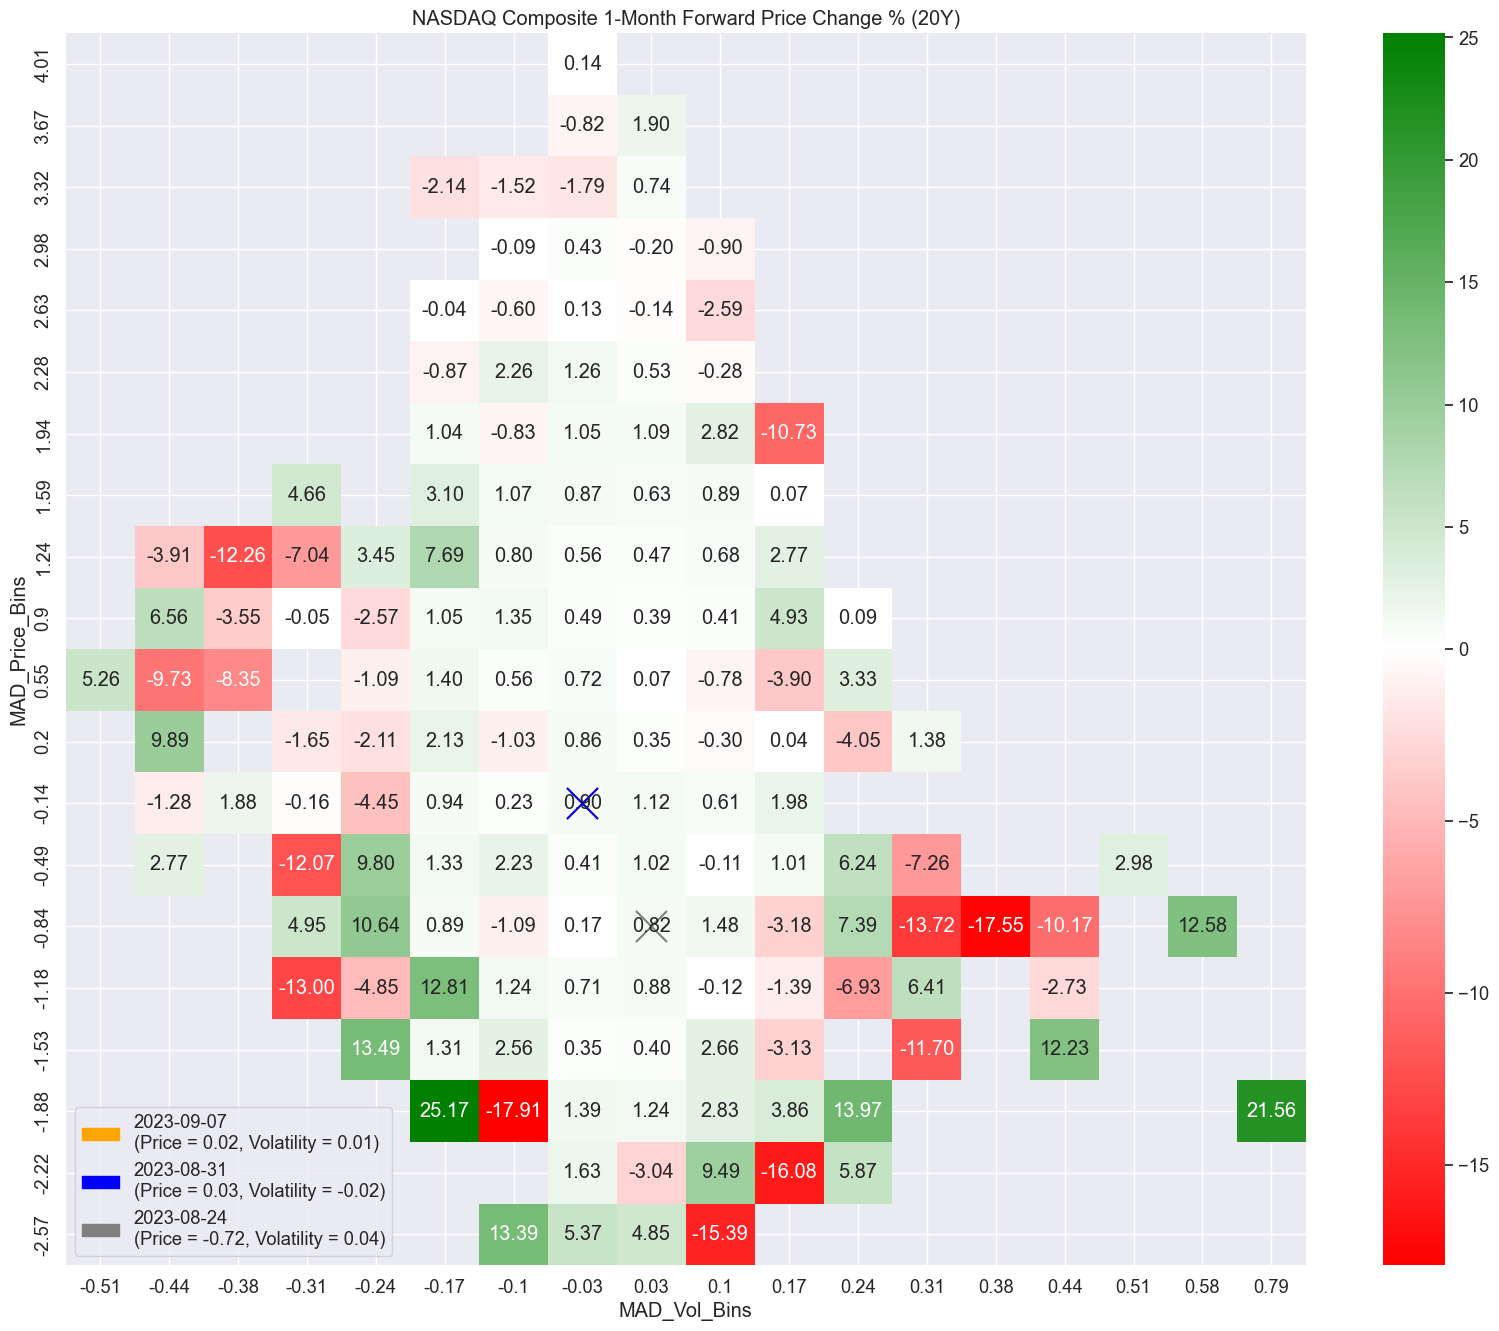

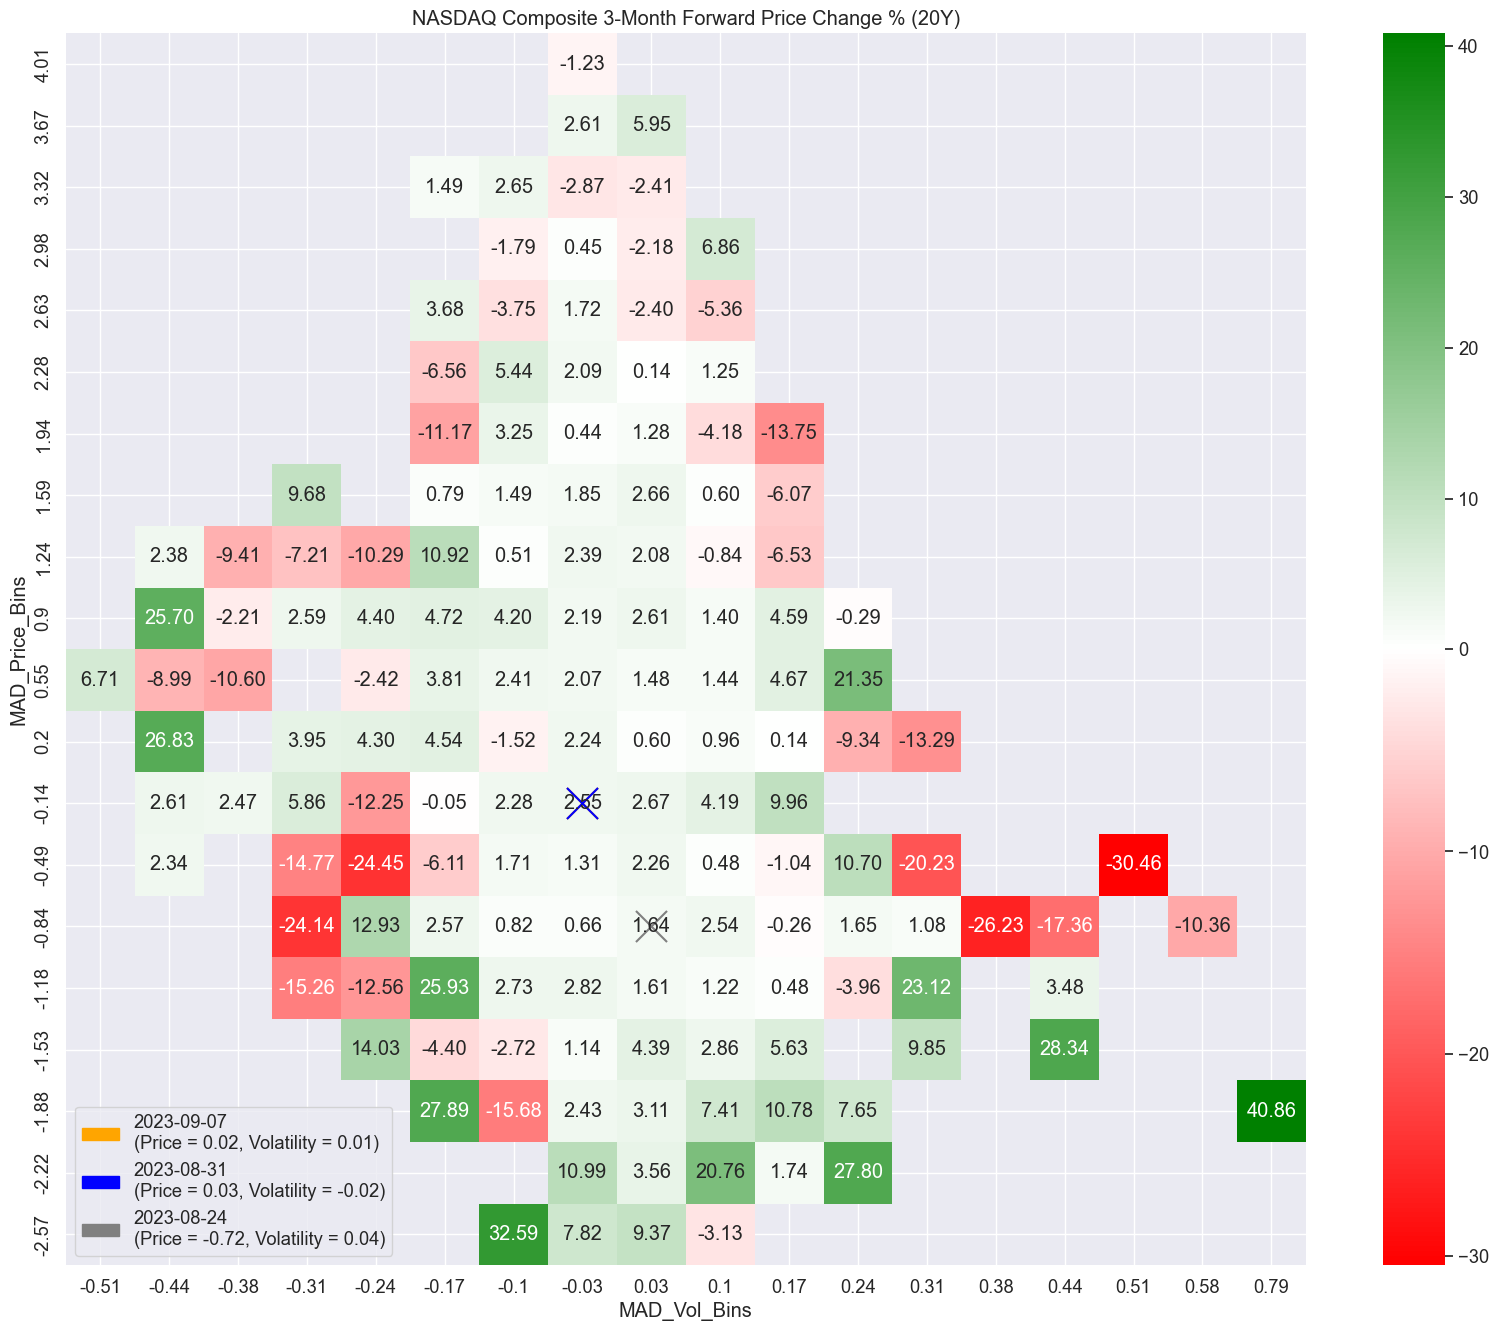

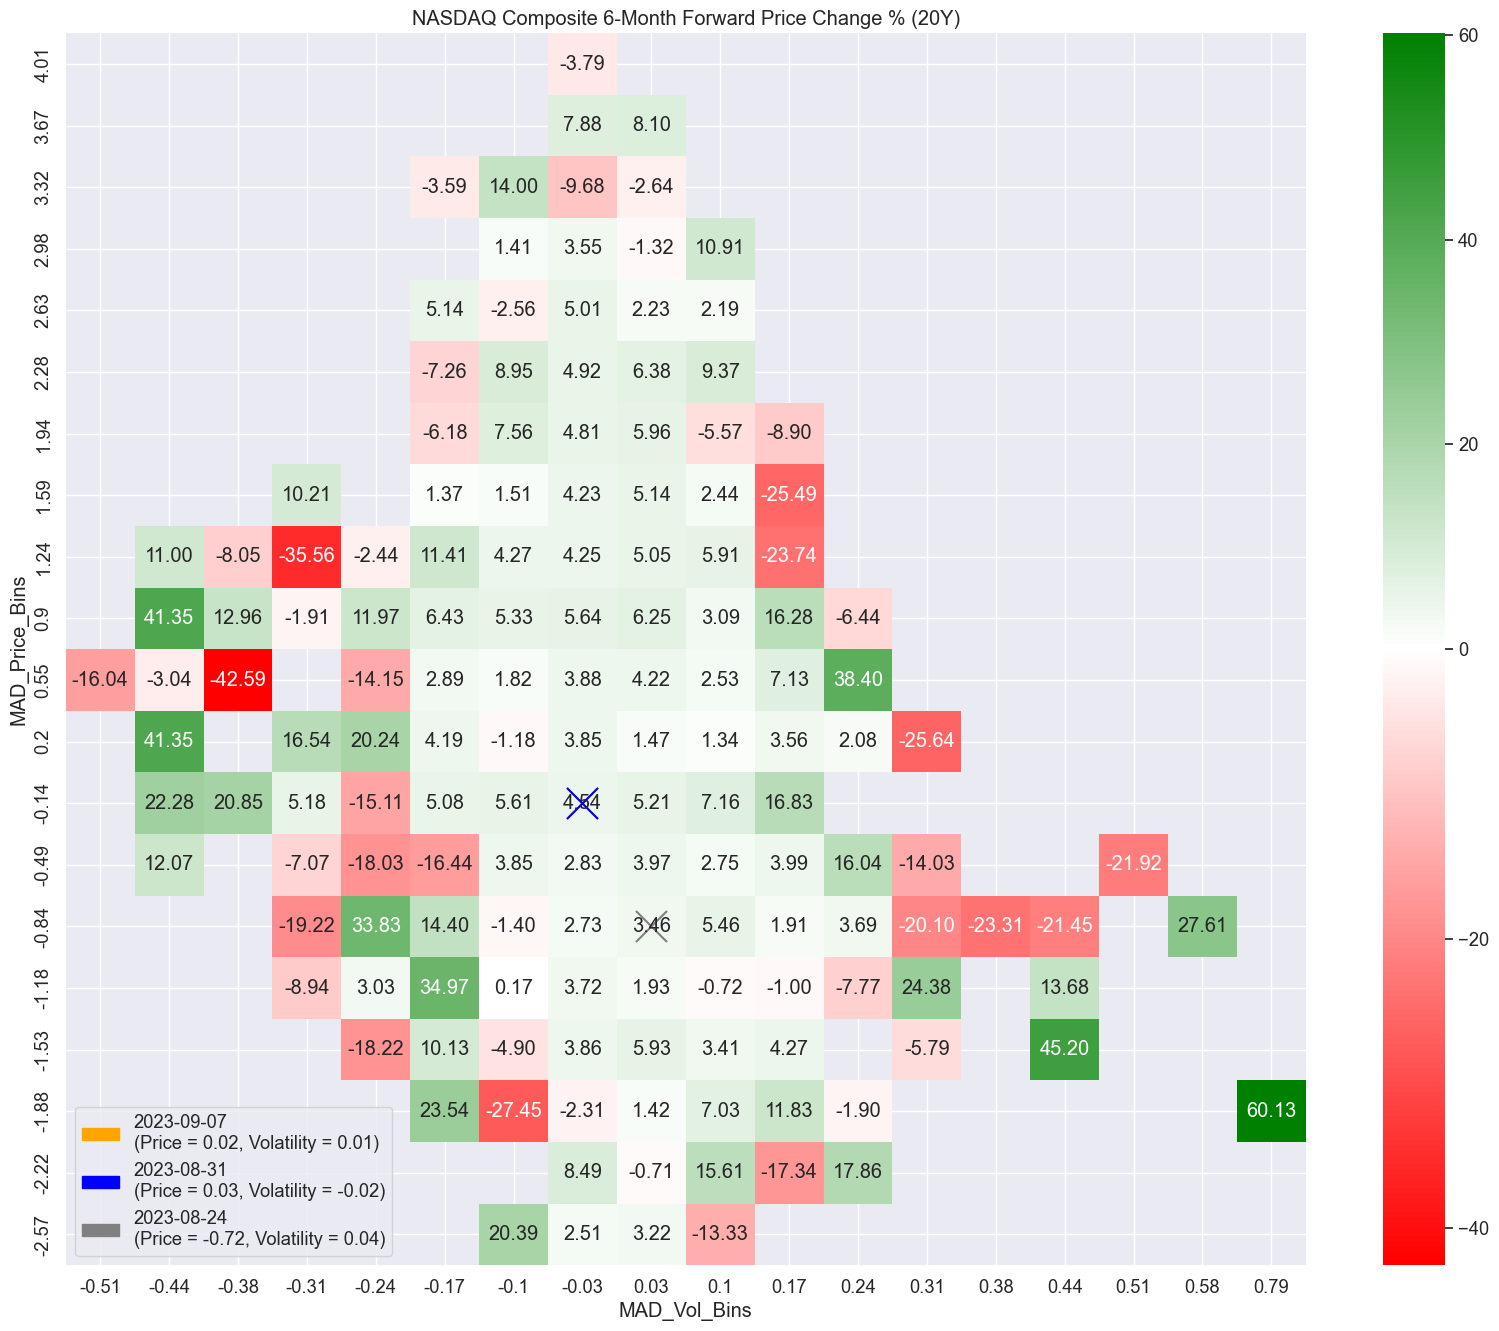

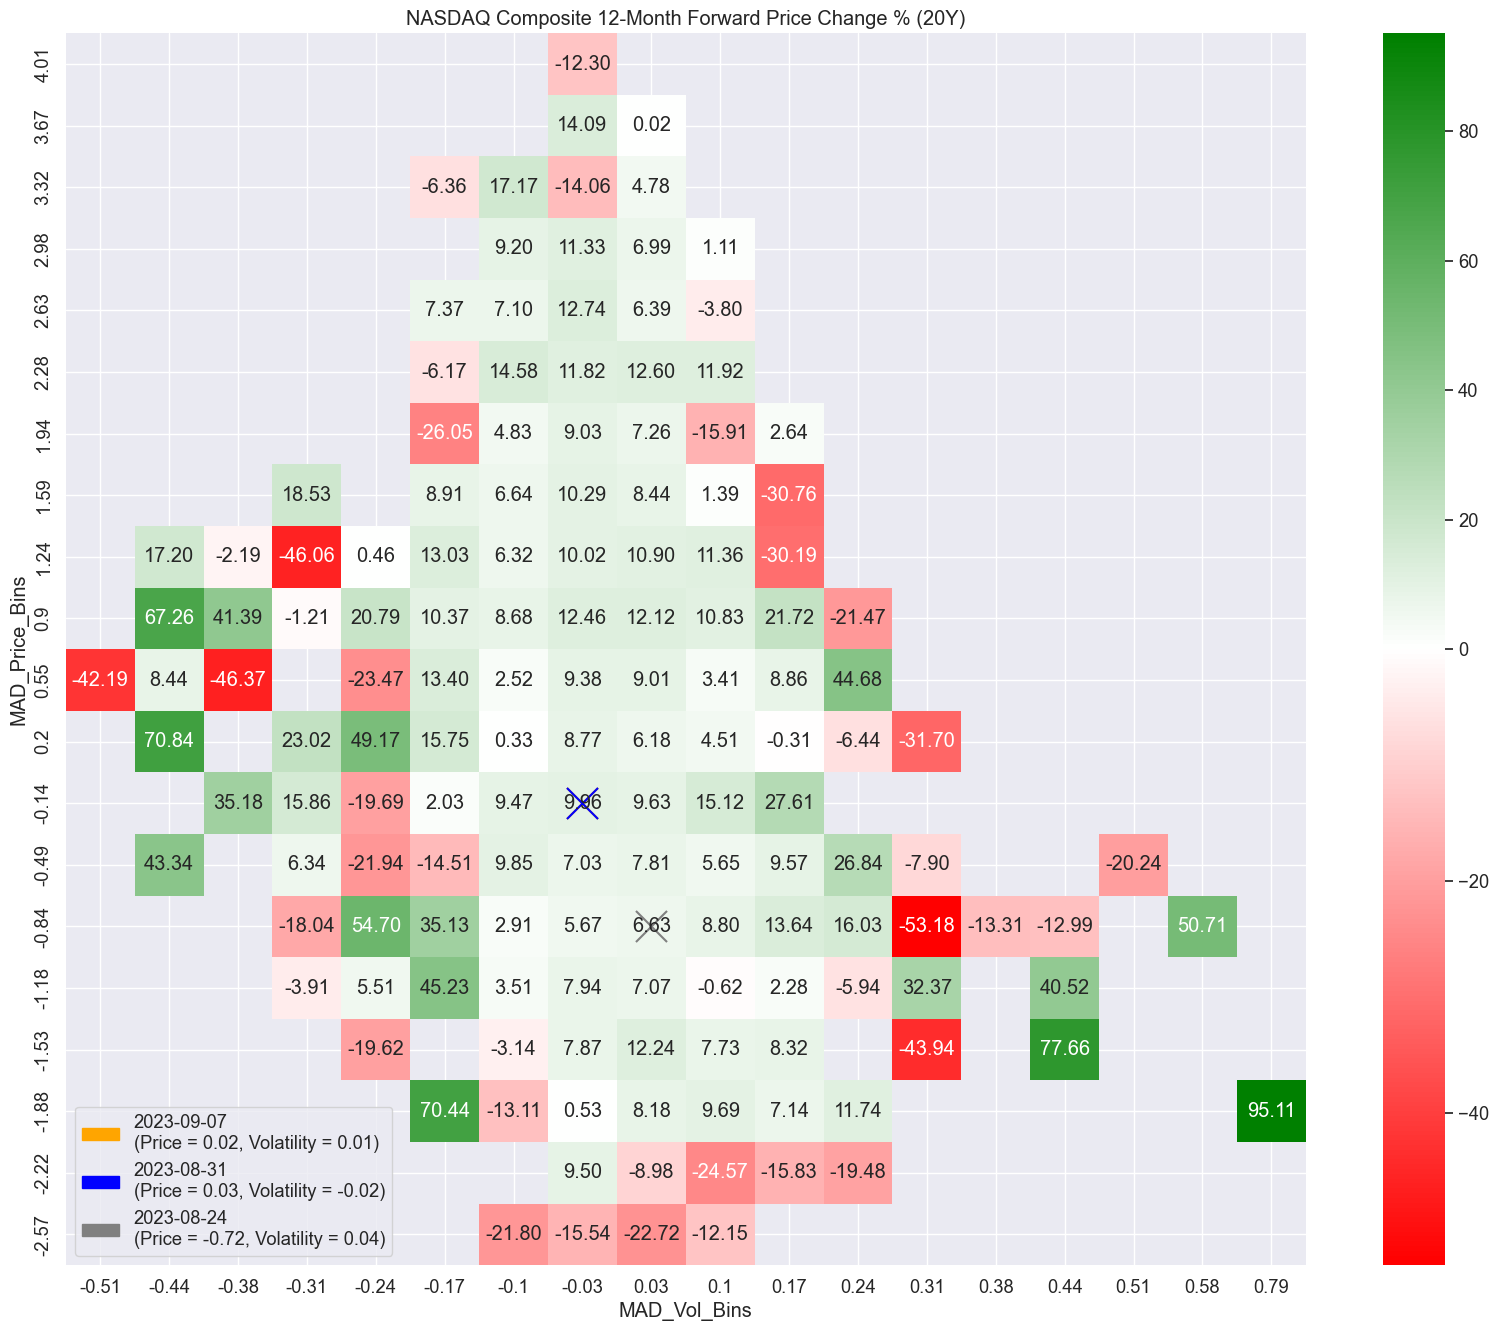

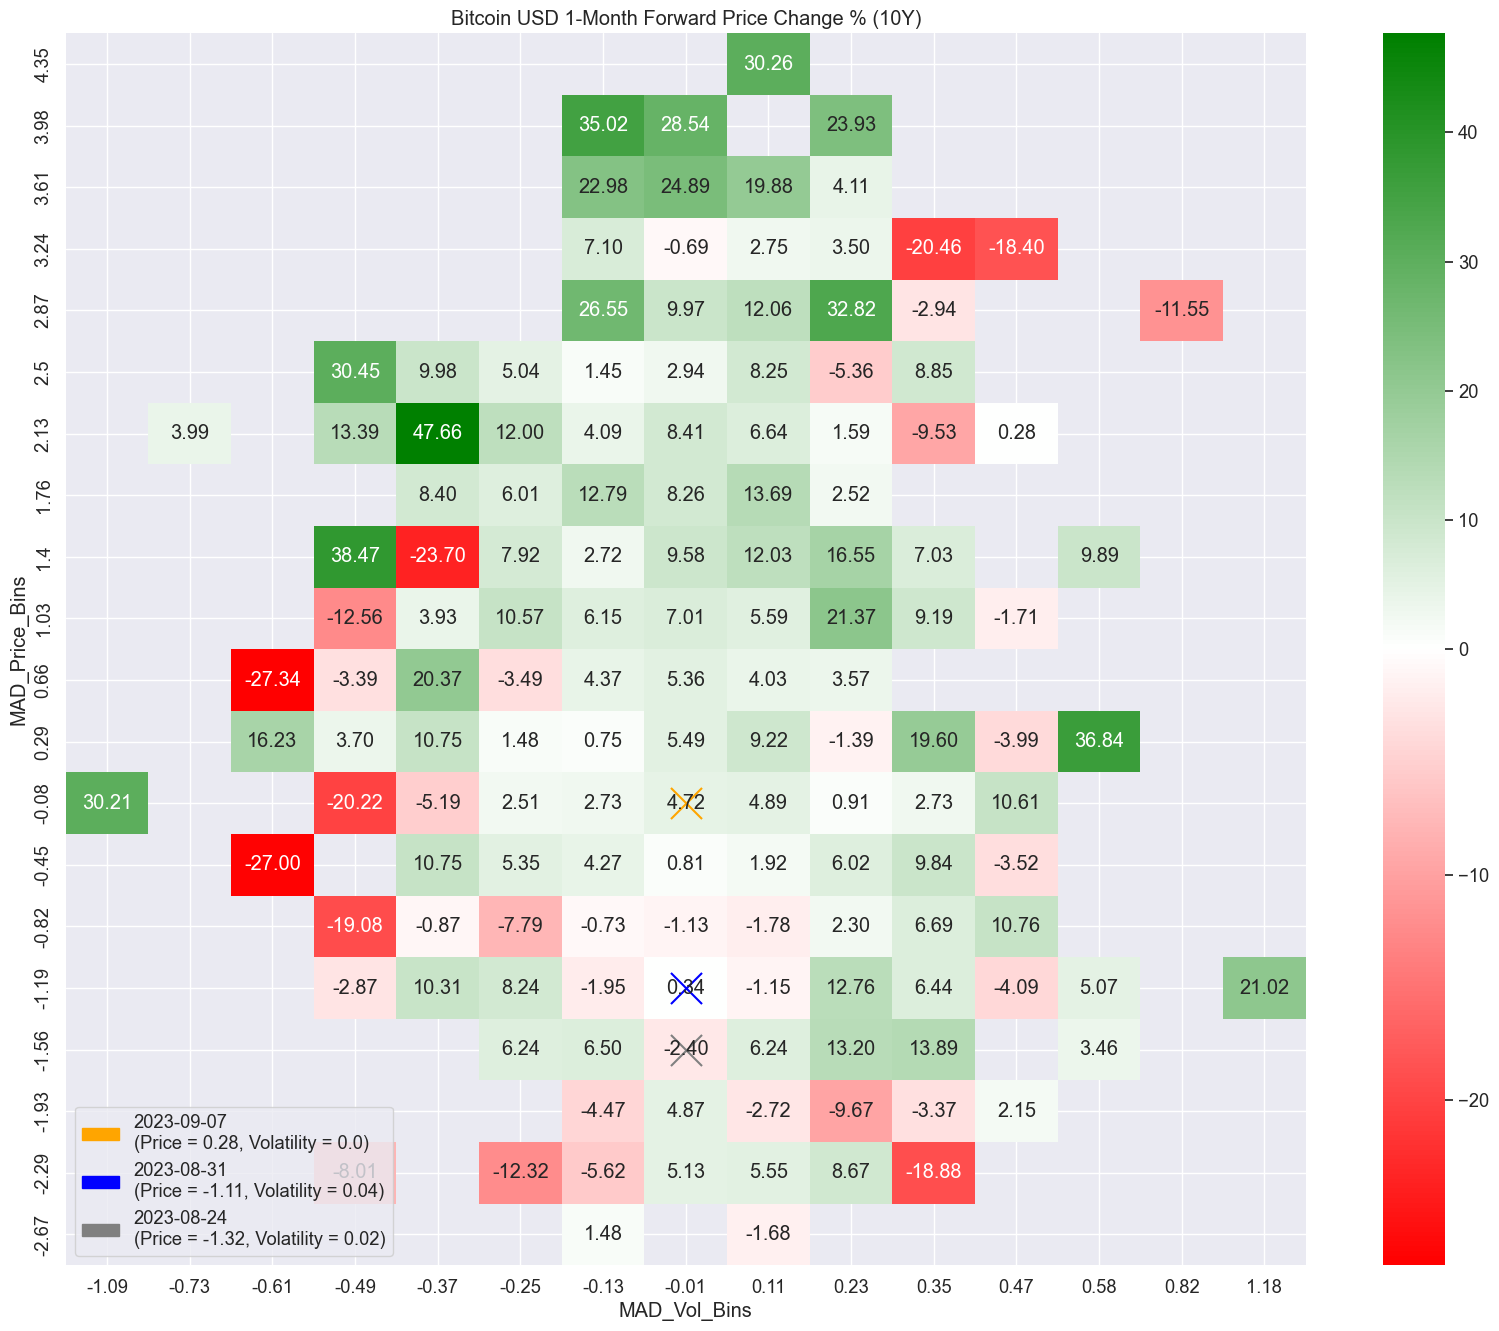

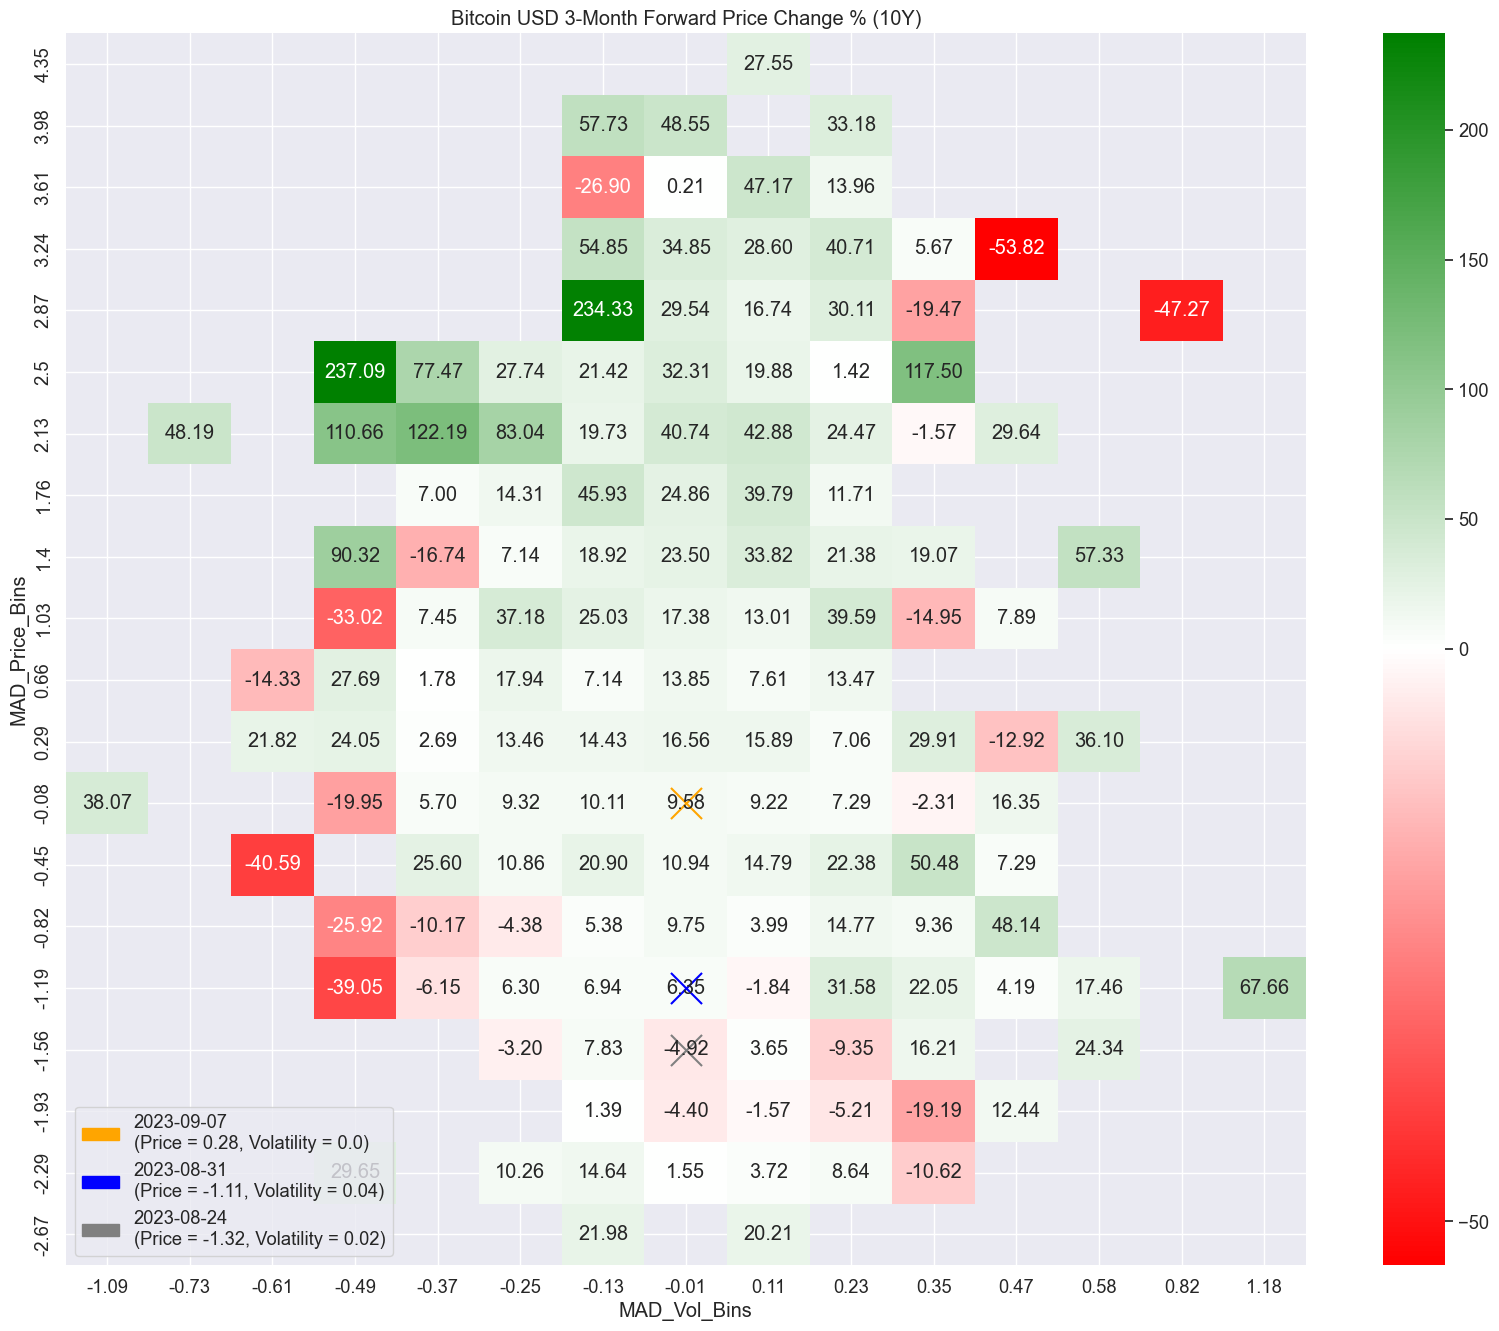

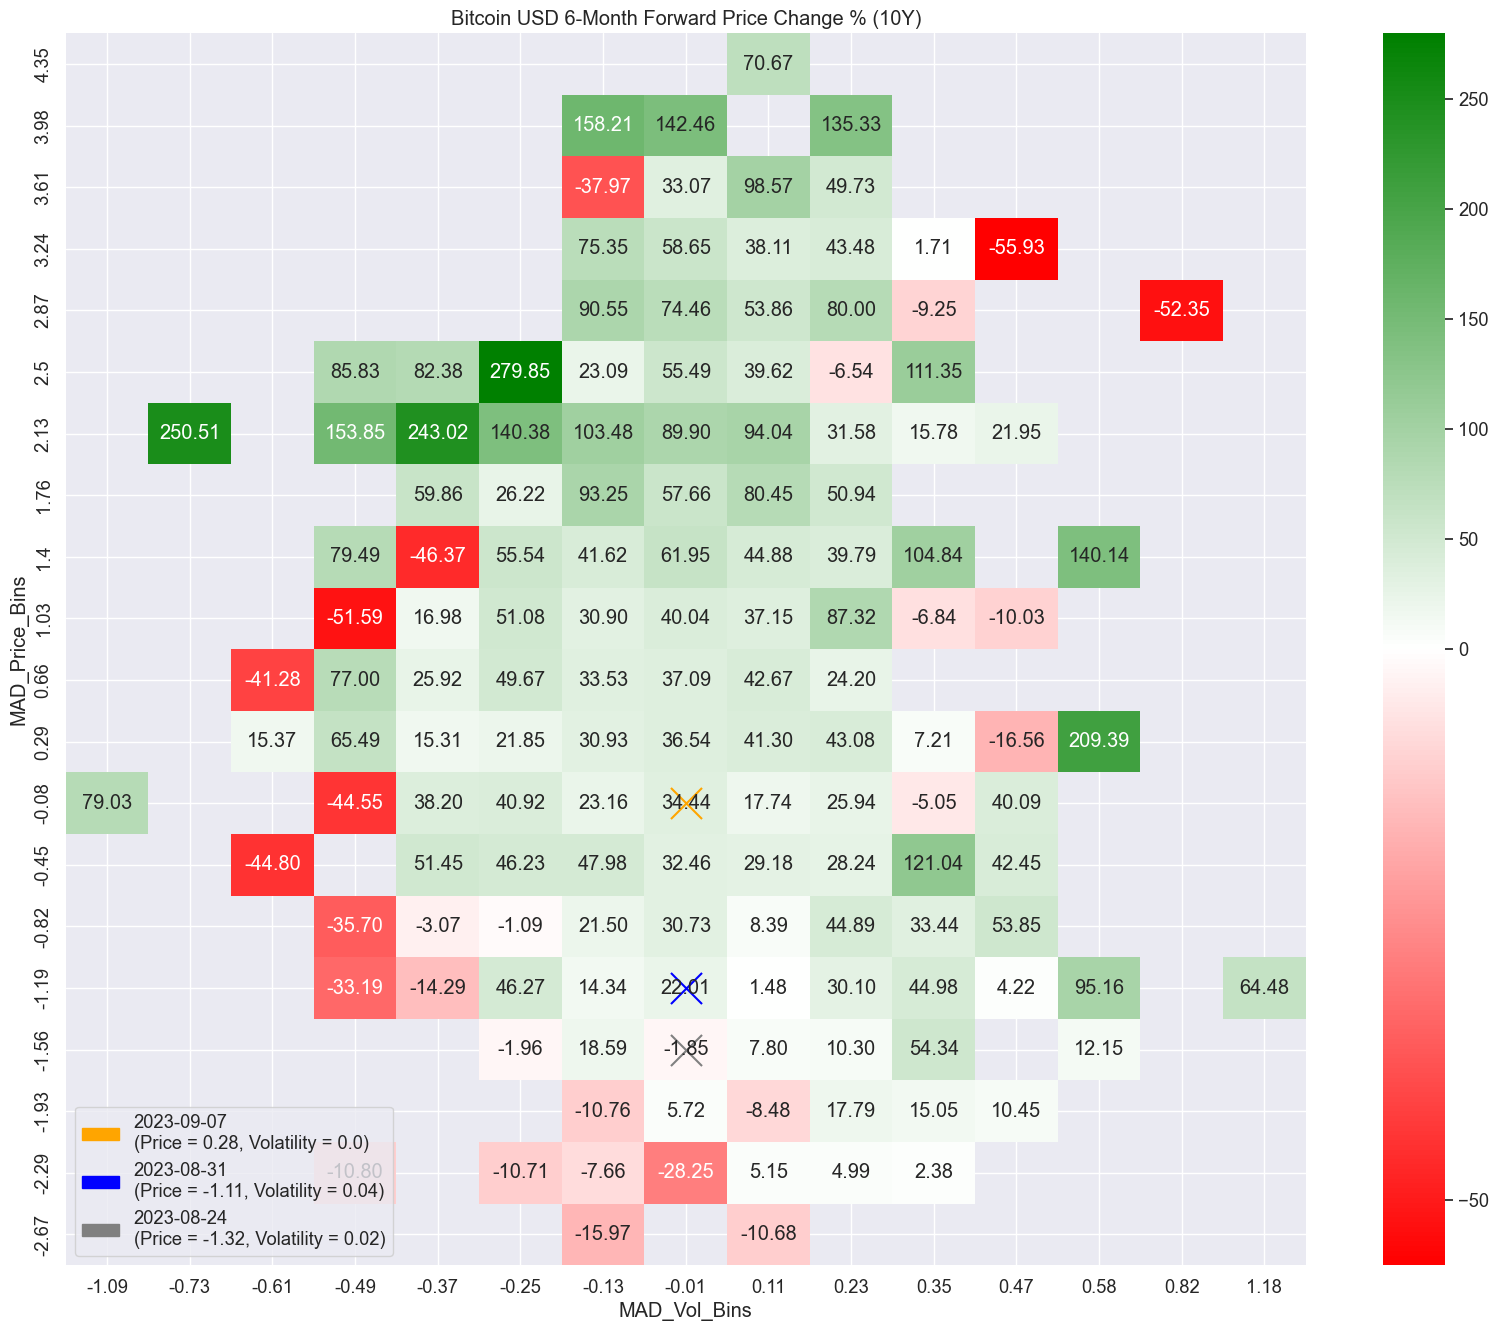

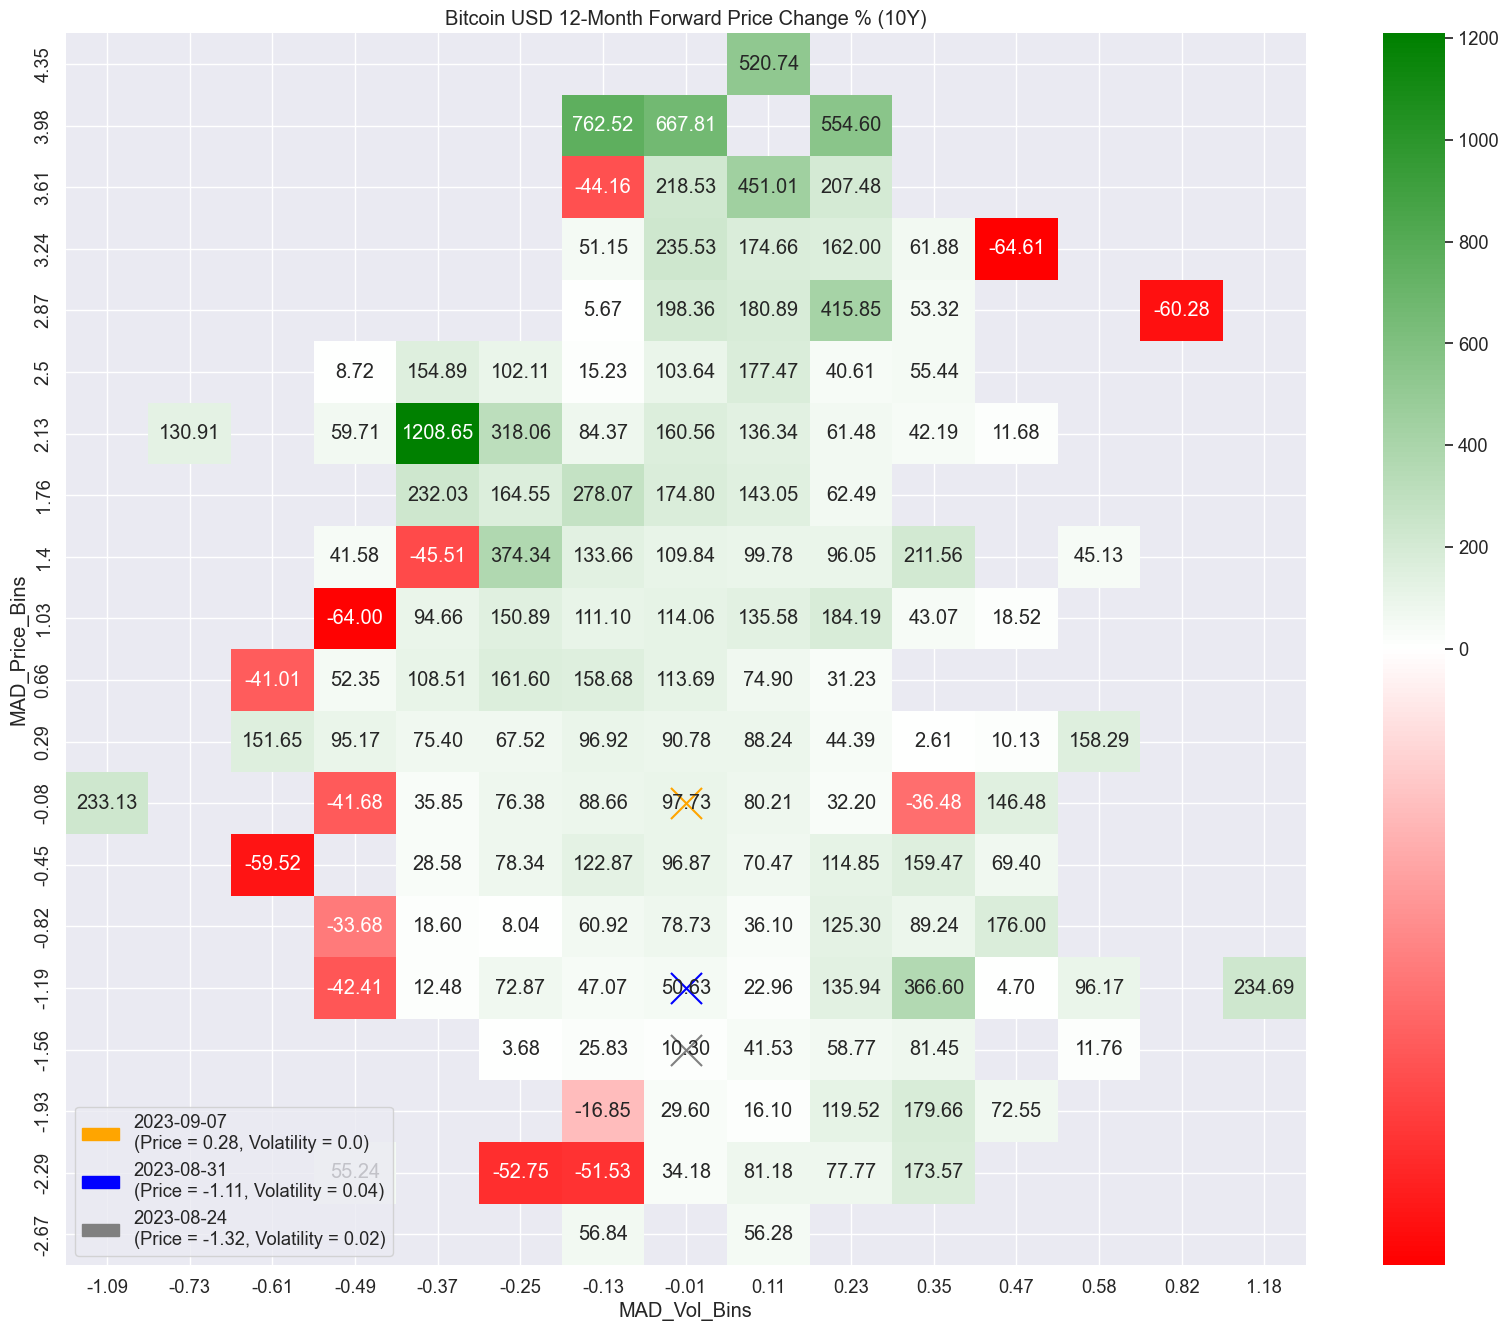

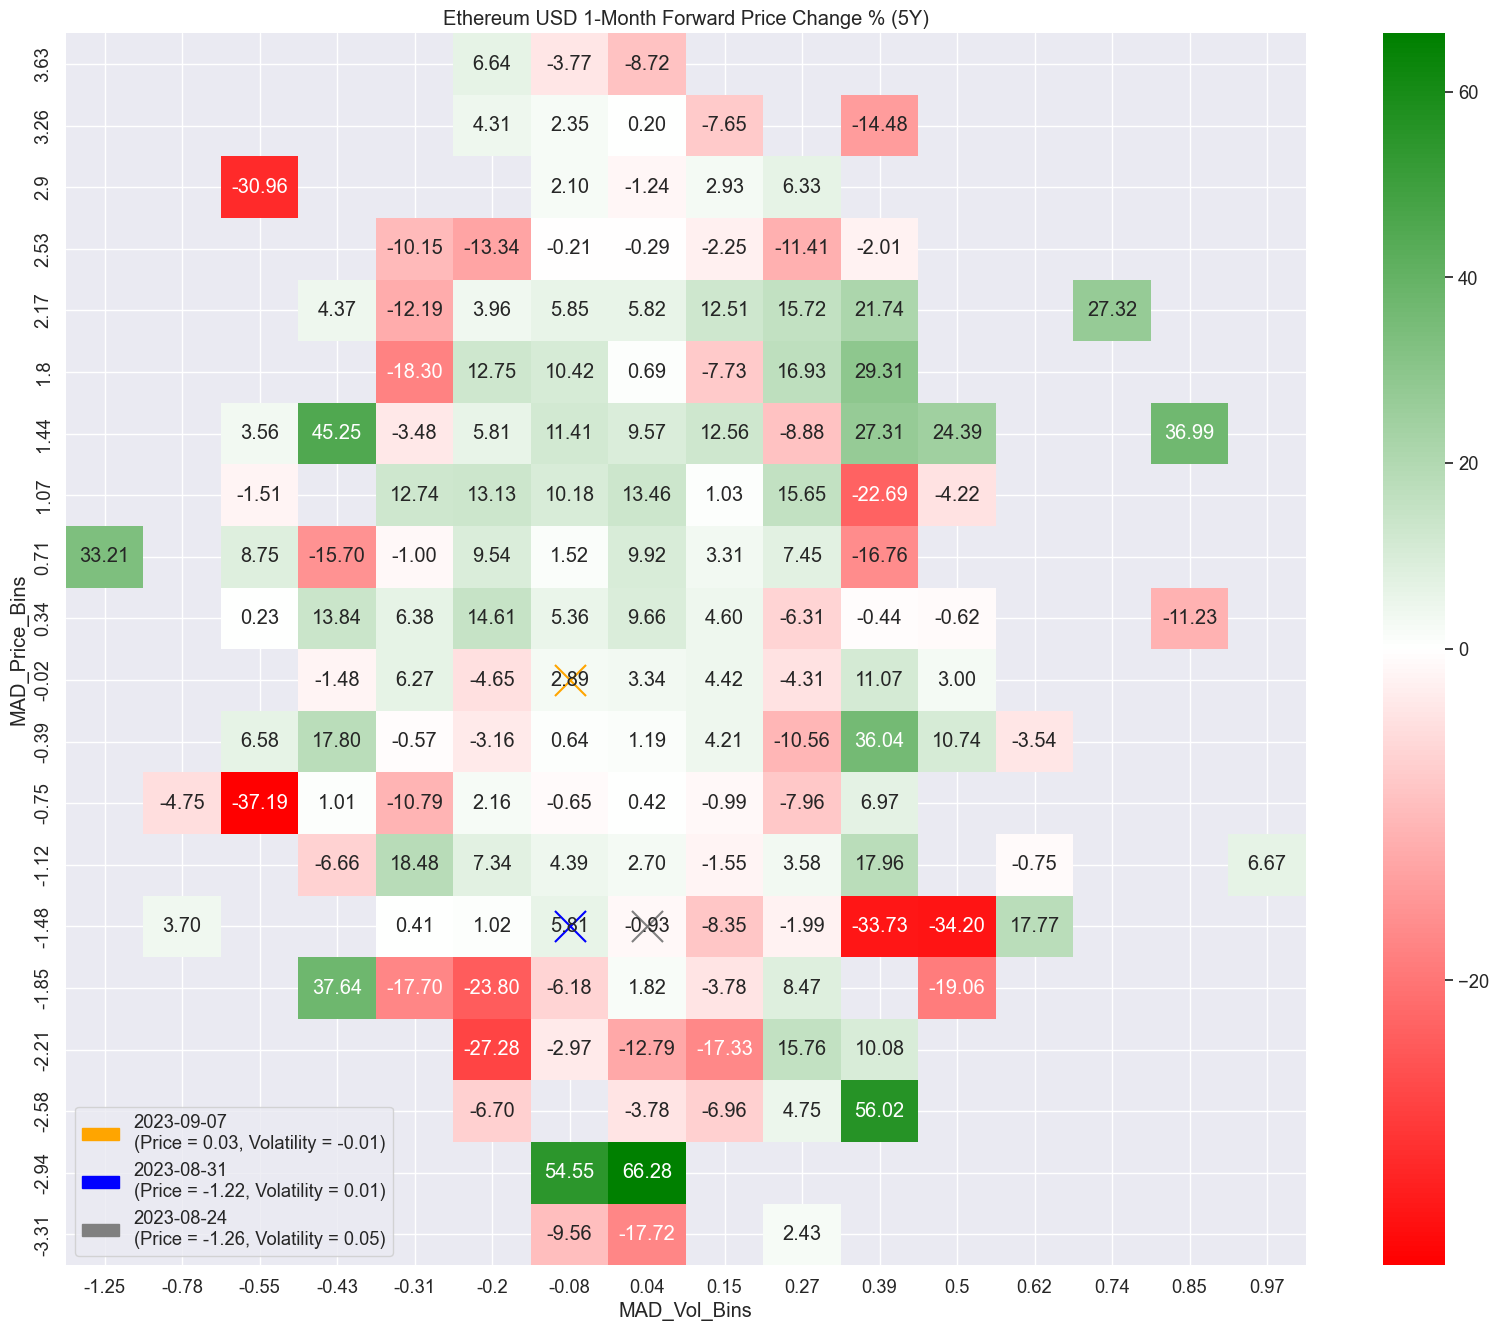

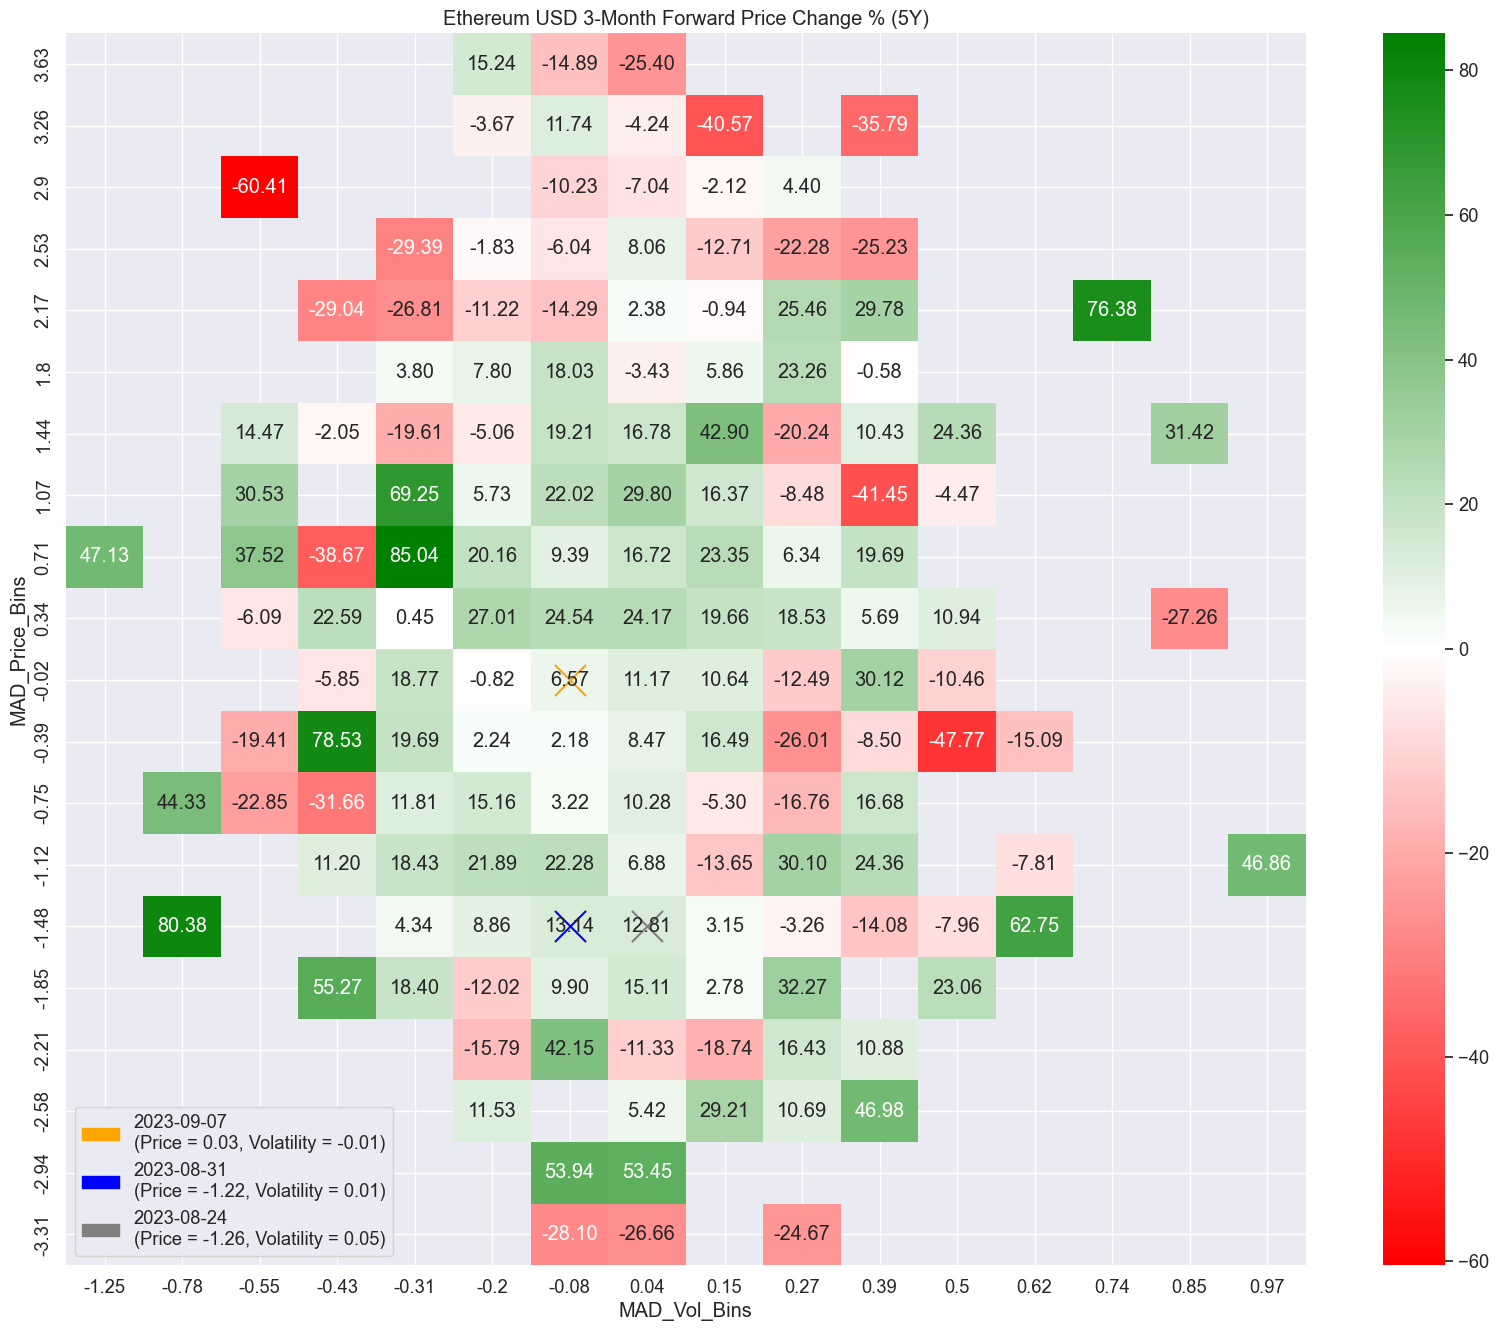

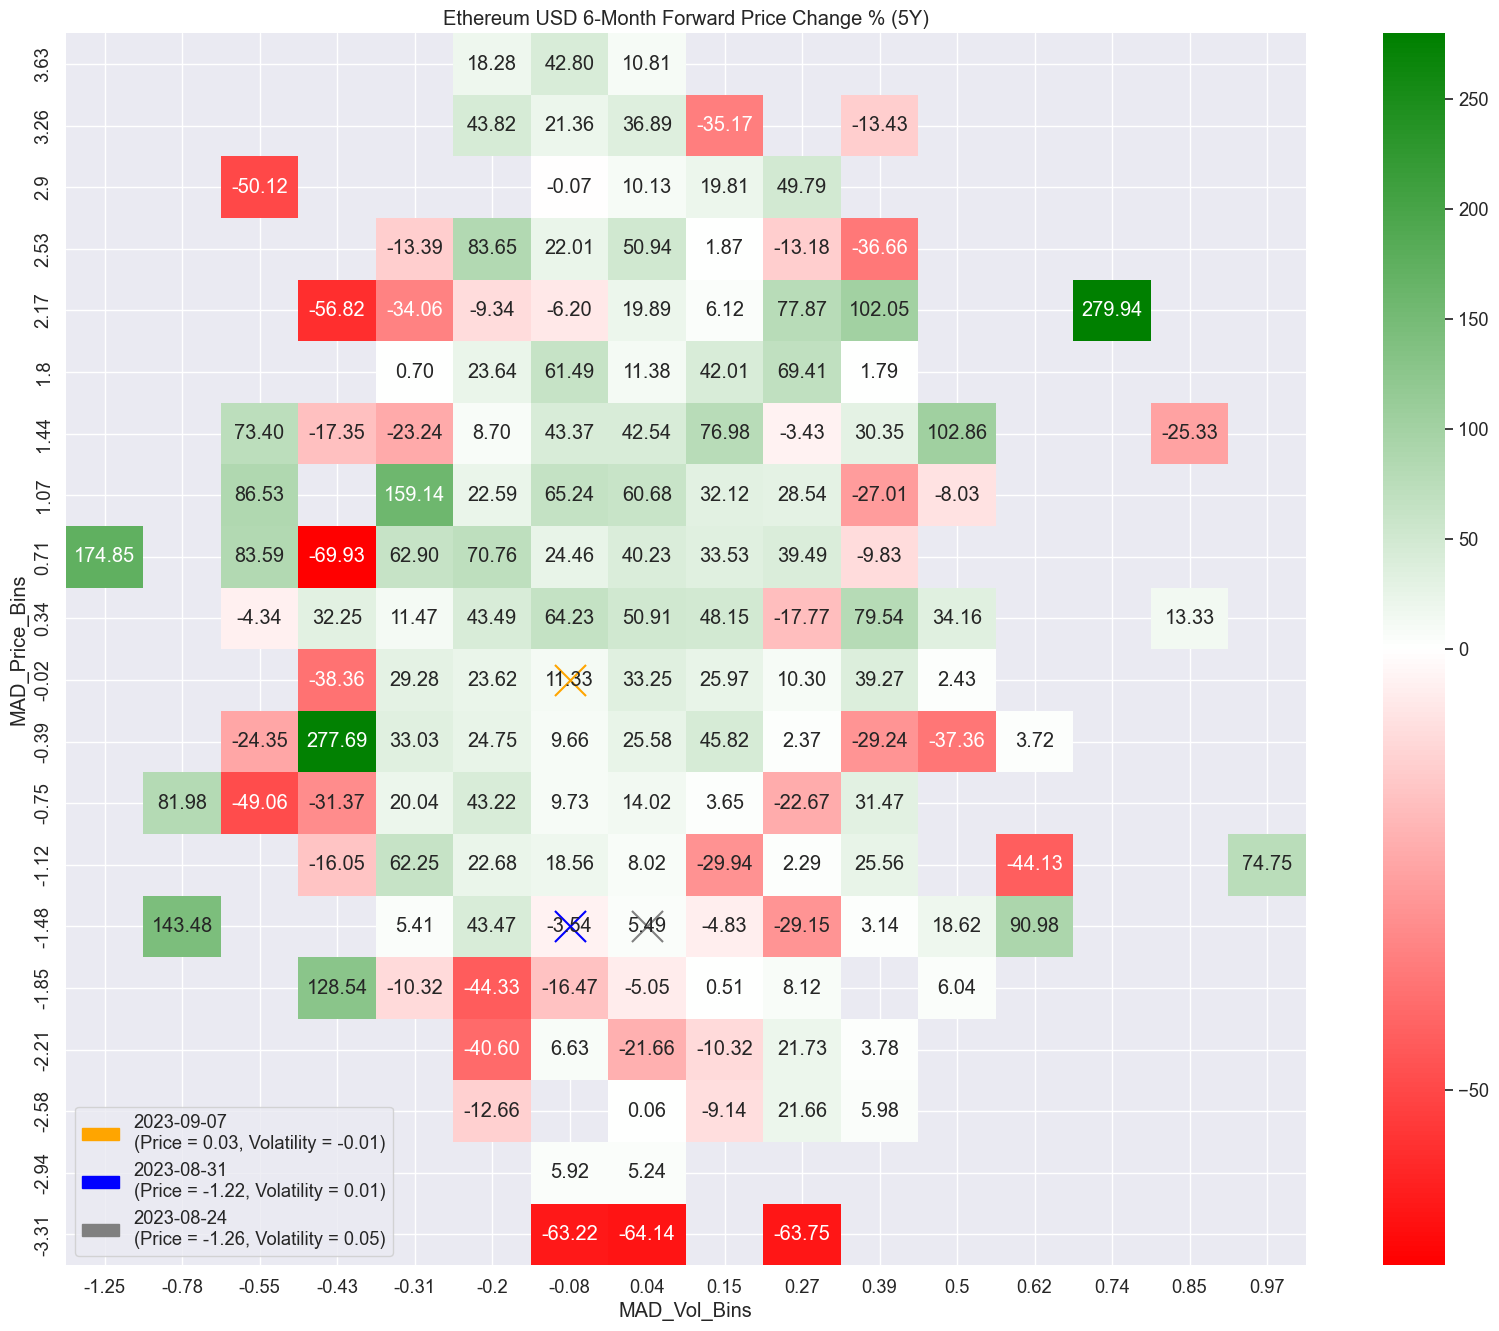

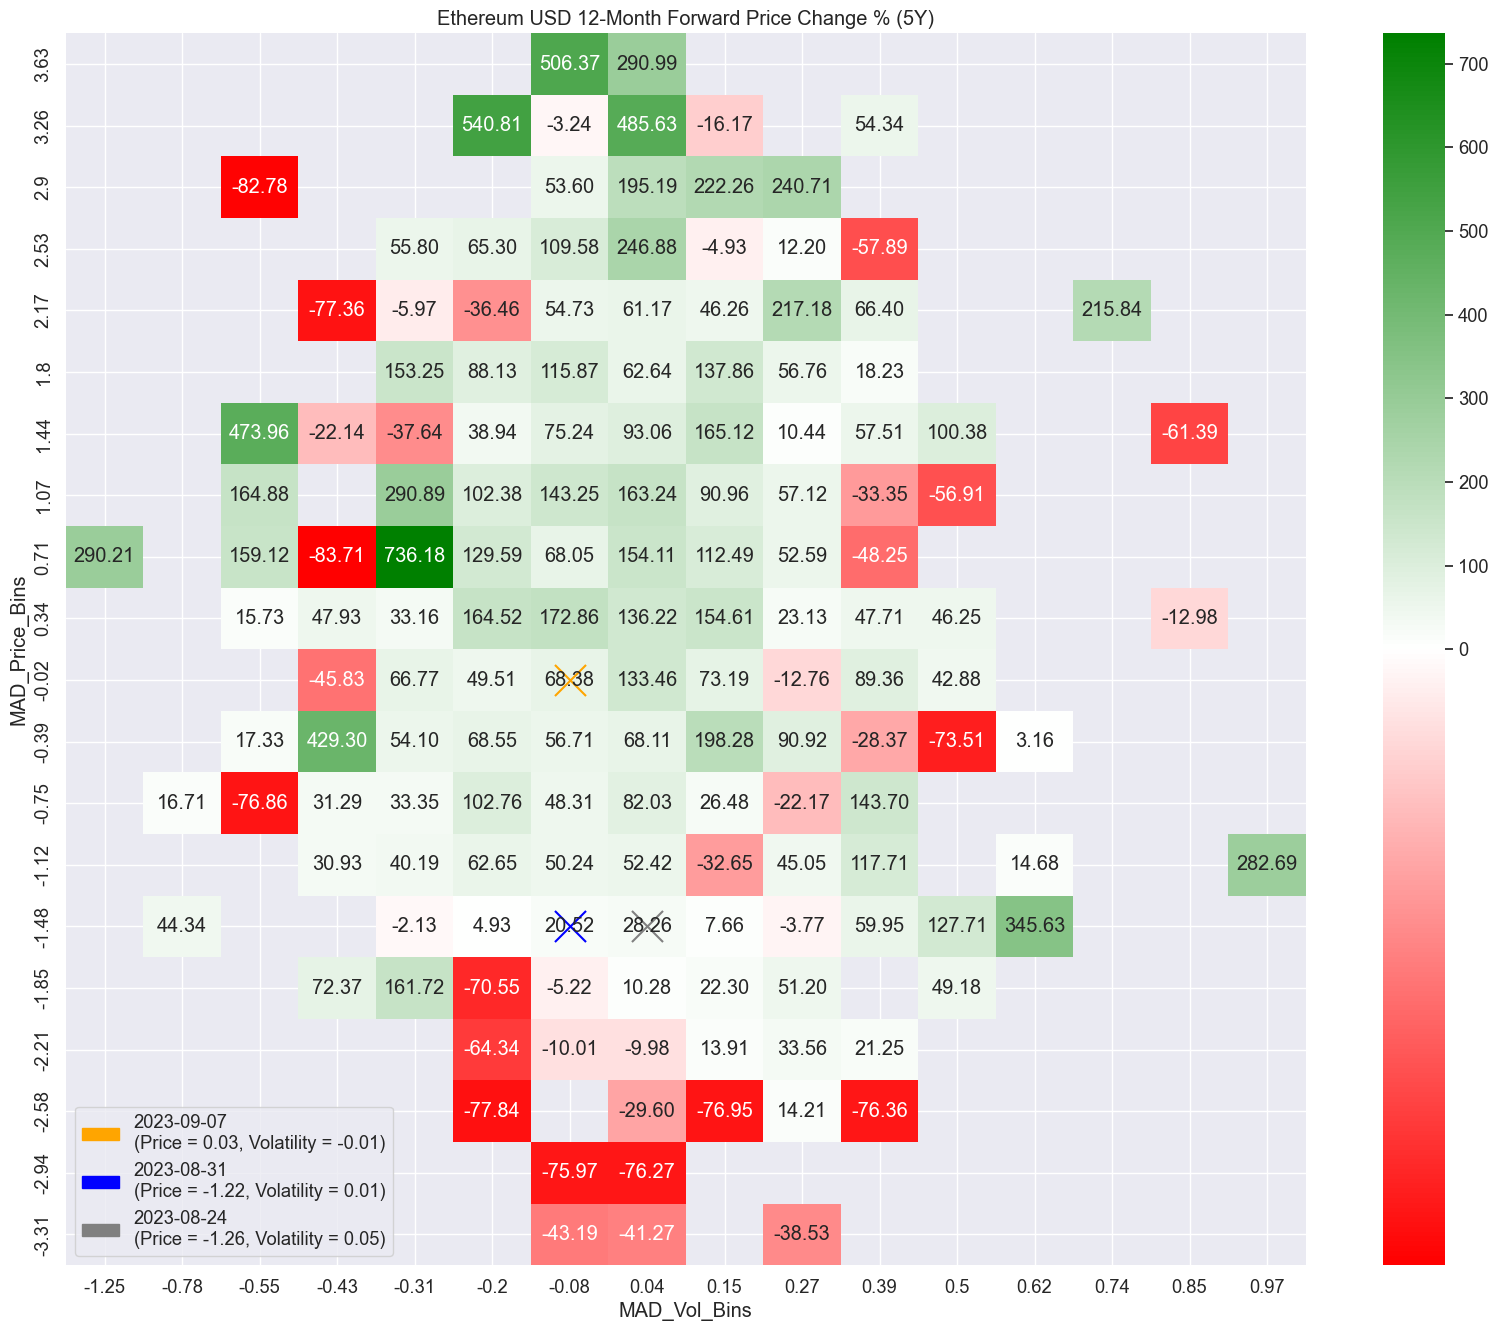

In [18]:
end_date = pd.Timestamp.now().strftime('%Y-%m-%d') 

date2 = (pd.Timestamp(end_date) - pd.Timedelta(weeks=1)).strftime('%Y-%m-%d')
date3 = (pd.Timestamp(end_date) - pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')
date4 = (pd.Timestamp(end_date) - pd.Timedelta(weeks=3)).strftime('%Y-%m-%d')

months_forward = 1

pdf_filenames = []
lol = ['SHIB-USD']
realt = ['^IXIC','BTC-USD','ETH-USD']
for tickers in realt :
    with PdfPages('{} MAD Heat Map.pdf'.format(yf.Ticker(tickers).info['shortName'])) as pdf_pages:
        for time in [1,3,6,12]:  # Or whatever list of tickers you want
            plot_mad_heatmap_to_pdf('{}'.format(tickers), '2000-01-01', end_date, [date2,date3,date4], time, pdf_pages)
            pdf_filenames.append('{} MAD Heat Map.pdf'.format(yf.Ticker(tickers).info['shortName']))